# Portfolio Optimization (with stocks) Code

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv("../sp500sub.csv", index_col='Date', parse_dates=True)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')

In [4]:
df['Name'].unique()

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [5]:
# Pick diverse company tickers

names = ['GOOG', 'SBUX', 'KSS', 'NEM']

In [6]:
# Using a six-month period
252/2

126.0

In [9]:
# Getting all the dates from df to select from later
all_dates = df.index.unique().sort_values()
len(all_dates)

2267

In [10]:
# Start date
all_dates.get_loc('2014-01-02')

1007

In [11]:
# End date
all_dates.get_loc('2014-06-30')

1130

In [12]:
start = all_dates.get_loc('2014-01-02')
end = all_dates.get_loc('2014-06-30')
dates = all_dates[start:end+1]

In [13]:
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [14]:
# six month period? - close enough
len(dates)

124

In [15]:
# Building a dataframe of close prices where each companies close price is side-by-side (easy to calc mean/cov)
close_prices = pd.DataFrame(index=dates)

In [16]:
for name in names:
    tmp_df = df.loc[dates]
    df_sym = tmp_df[tmp_df['Name'] == name]
    tmp_cls_df = pd.DataFrame(data=df_sym['Close'].to_numpy(), index=df_sym.index, columns=[name])
    close_prices = close_prices.join(tmp_cls_df)

In [17]:
# Quick check to see if it looks ok - Yes
close_prices.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-02,554.481689,38.584999,56.990002,23.959999
2014-01-03,550.436829,38.474998,56.860001,23.920000
2014-01-06,556.573853,38.084999,56.040001,24.080000
2014-01-07,567.303589,38.605000,56.099998,23.950001
2014-01-08,568.484192,39.014999,55.180000,23.400000


In [18]:
# Checking for missing data
close_prices.isna().sum().sum()

0

In [19]:
# New empty dataframe to store the returns 
# indexing is +1 since it will be differenced

returns = pd.DataFrame(index=dates[1:])

In [20]:
for name in names:
    # Log results
    current_returns = close_prices[name].pct_change()
    returns[name] = current_returns.iloc[1:] * 100  # percentace format

In [21]:
returns.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-03,-0.729485,-0.285086,-0.228112,-0.166941
2014-01-06,1.114937,-1.013644,-1.442138,0.668896
2014-01-07,1.927819,1.365368,0.107062,-0.539864
2014-01-08,0.208108,1.062038,-1.639925,-2.296456
2014-01-09,-0.962997,-0.551071,0.688657,-0.854696


In [23]:
# Calc mean daily return (over period)

mean_return = returns.mean()
mean_return

GOOG    0.038691
SBUX    0.009955
KSS    -0.053793
NEM     0.072932
dtype: float64

In [24]:
# Covariance

cov = returns.cov()
cov

,GOOG,SBUX,KSS,NEM
GOOG,2.206565,0.832469,0.771772,-0.033600
SBUX,0.832469,1.558406,0.714586,0.374448
KSS,0.771772,0.714586,2.025854,0.180308
NEM,-0.033600,0.374448,0.180308,4.815104


In [25]:
# Converting Covariance matrix into a np array for easier iterating.

cov_np = cov.to_numpy()

Getting back to the portfolio parts...

In [26]:
# Generating random portfolios

N = 1000
D = len(mean_return)

returns = np.zeros(N)
risks = np.zeros(N)

for i in range(N):
    # Random weight vector
    rand_range = 1.0
    w = np.random.random(D)*rand_range - rand_range / 2   # with short selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    ret = mean_return.dot(w)
    risk = np.sqrt(w.dot(cov_np).dot(w))
    returns[i] = ret
    risks[i] = risk

In [28]:
# Returns and Risks for single asset portfolios (E.g. ONLY investing in 'GOOG')

single_asset_returns = np.zeros(D)
single_asset_risks = np.zeros(D)

for i in range(D):
    ret = mean_return[i]
    risk = np.sqrt(cov_np[i, i])

    single_asset_returns[i] = ret
    single_asset_risks[i] = risk 

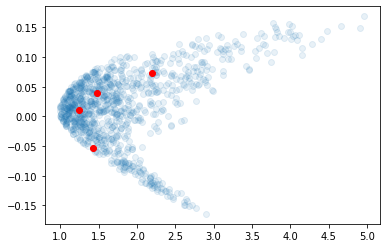

In [29]:
plt.scatter(risks, returns, alpha=0.1)  # Random Portfolios
plt.scatter(single_asset_risks, single_asset_returns, c='red')  # Individual assets

The above plot shows that there is lots of room to adjust the weights for a portfolio containing our 4 stocks and get as good a return with much less risk.
- By adjusting horizontally/vertically